In [1]:
import xarray as xr
import gcsfs
import pandas as pd
from dask.distributed import Client
import gcsfs
fs = gcsfs.GCSFileSystem(token="anon")

In [ ]:
import numpy as np
from dask.diagnostics import ProgressBar

# Path to ARCO-ERA5 Zarr store
gcs_path = "gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3"

# Open dataset with dask
ds = xr.open_zarr(
    gcs_path,
    chunks={"time": 365},   
    storage_options={"token": "anon"}
)

# Create SST and TCWV data arrays
ds_sst  = ds['sea_surface_temperature']
ds_tcwv = ds['total_column_water_vapour']

In [ ]:
# Extract the land-sea mask 
mask = ds['land_sea_mask'].isel(time=0)  
mask = mask.astype(bool)

# Select spatial region
mask_region = mask.sel(latitude=slice(65, -65), longitude=slice(120, 300))

# Apply the land-sea mask to SST and TCWV
# (Set land values to NaN)
ds_region = ds.sel(latitude=slice(65, -65), longitude=slice(120, 300))
sst = ds_region['sea_surface_temperature'].where(~mask_region)
tcwv = ds_region['total_column_water_vapour'].where(~mask_region)

In [4]:
# Select desired time period
sst = sst.sel(time=slice("1979-01-01", "2024-12-31"))
tcwv = tcwv.sel(time=slice("1979-01-01", "2024-12-31"))

# Convert to monthly mean
sst_monthly  = sst.resample(time="1M").mean(dim="time")
tcwv_monthly = tcwv.resample(time="1M").mean(dim="time")



/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [5]:
# Compute SST climatology baseline 1981-2010
sst_clim = sst_monthly.sel(time=slice("1979-01-01", "2024-12-31")).groupby("time.month").mean(dim="time")
sst_anom = (sst_monthly.groupby("time.month") - sst_clim)




The following steps were performed to speed up the calculation and prevent future slow-downs. Several netcdf files were created.

In [6]:
ds_out = xr.Dataset(
    {
        "sst_anomaly": sst_anom,
        "tcwv": tcwv_monthly,
    },
    coords={
        "time": sst_monthly.time,
        "latitude": ds_region.latitude,
        "longitude": ds_region.longitude,
    },
)

In [8]:
from dask.diagnostics import ProgressBar
import dask

dask.config.set(scheduler='threads')  # lightweight, good for CPU-bound tasks

ds_out_chunked = ds_out.chunk({
    "time": 12,
    "latitude": 256,
    "longitude": 256
})

encoding = {
    "sst_anomaly": {"zlib": True, "complevel": 4, "dtype": "float32"},
    "tcwv": {"zlib": True, "complevel": 4, "dtype": "float32"},
}

output_file = "1979_2024_SST_TCWV.nc"

with ProgressBar():
    ds_out_chunked.to_netcdf(
        output_file,
        encoding=encoding,
        compute=True
    )
print("Done")


[########################################] | 100% Completed | 100m 52s
Done


In [7]:
# Open the NetCDF file
netcdf_ds = xr.open_dataset("1979_2024_SST_TCWV.nc")

# Inspect variables and coordinates
print(netcdf_ds)


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 552, latitude: 521, longitude: 721)
Coordinates:
  * time         (time) datetime64[ns] 4kB 1979-01-31 1979-02-28 ... 2024-12-31
  * latitude     (latitude) float32 2kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude    (longitude) float32 3kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    month        (time) int64 4kB ...
Data variables:
    sst_anomaly  (time, latitude, longitude) float32 829MB ...
    tcwv         (time, latitude, longitude) float32 829MB ...


In [8]:
# Re-select anomaly and tcwv variables
sst_anom_comp = netcdf_ds['sst_anomaly']
tcwv_comp = netcdf_ds['tcwv']
print(sst_anom_comp)

<xarray.DataArray 'sst_anomaly' (time: 552, latitude: 521, longitude: 721)> Size: 829MB
[207353832 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-31 1979-02-28 ... 2024-12-31
  * latitude   (latitude) float32 2kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float32 3kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    month      (time) int64 4kB ...


In [9]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


In [10]:
detr = linear_detrend(netcdf_ds[["sst_anomaly", "tcwv"]])   # or just ds if you want all float vars
anom, z = monthly_anom_and_z(detr,
                             base_period=("1981-01-01", "2010-12-31"))  # or None for full-period

print(type(z), list(z.data_vars))   # should show a Dataset with ['sst','tcrw']

/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var =

<class 'xarray.core.dataset.Dataset'> ['sst_anomaly', 'tcwv']


In [12]:
# z.to_netcdf('Z_netcdf.nc')
z_netcdf = xr.open_dataset('Z_netcdf.nc')

sst_std = z['sst_anomaly']

In [13]:
from eofs.xarray import Eof

# Create an EOF solver to do the EOF analysis. Square-root of cosine of latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_std.coords['latitude'].values))

wgts = np.sqrt(coslat)[..., np.newaxis]

solver = Eof(sst_std, weights=wgts)

In [14]:
# Obtain first 5 EOFs, PCs(time series) and Variance Fractions
eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)
variance_fractions = solver.varianceFraction(neigs=5)


In [17]:
eof1.to_netcdf("EOFs.nc")
pc1.to_netcdf("PCs.nc")
variance_fractions.to_netcdf("VarianceFraction.nc")

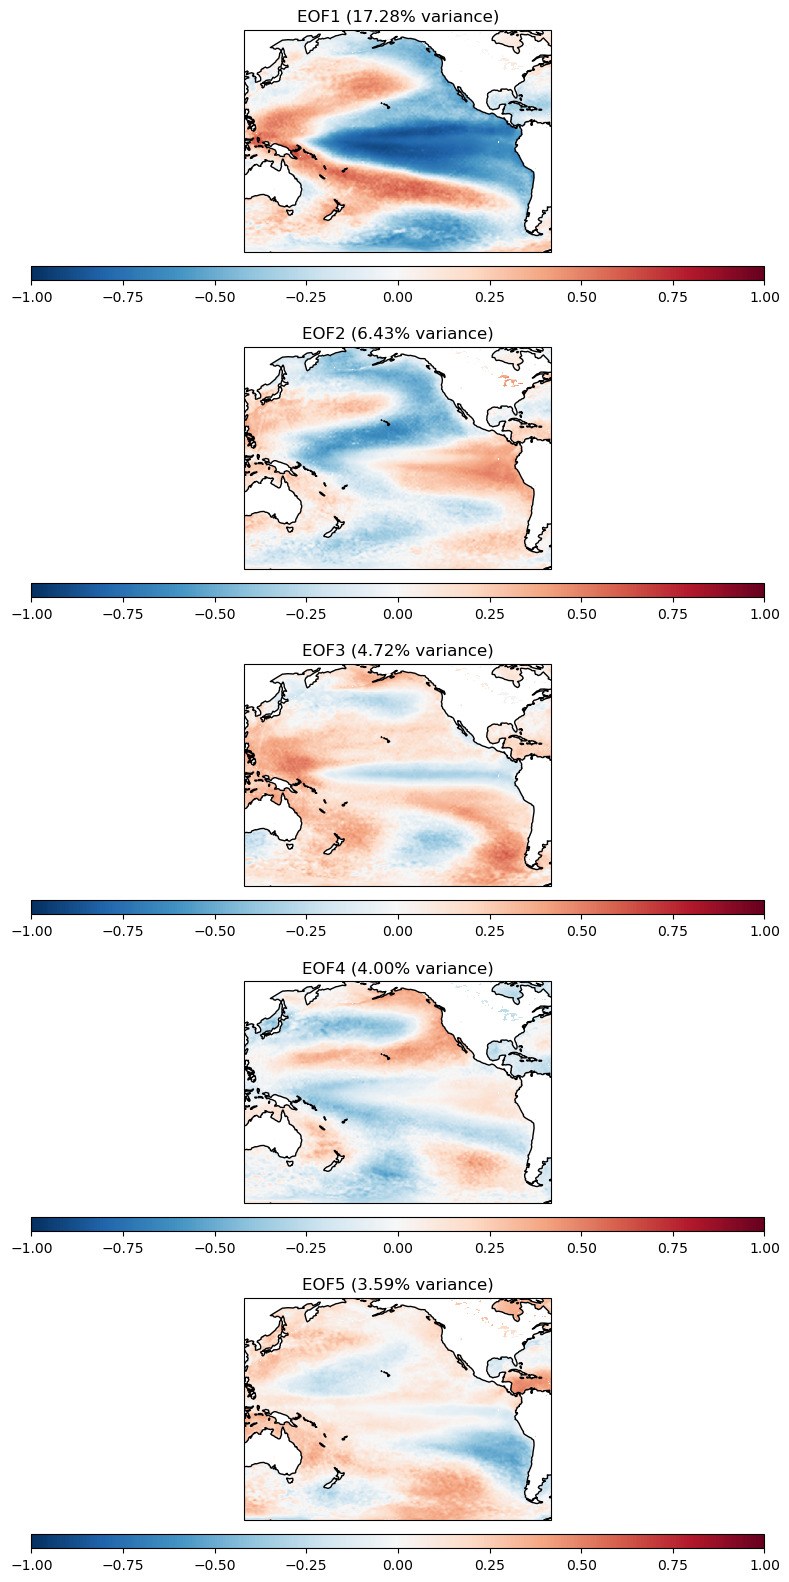

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


# Plot first 5 EOFs with corresponding variance fractions
proj = ccrs.PlateCarree(central_longitude=180)

fig, axes = plt.subplots(
    nrows=5, ncols=1,
    figsize=(8, 16),
    subplot_kw={'projection': proj}
)

for i, ax in enumerate(axes):
    eof = eof1.isel(mode=i)
    var_frac = float(variance_fractions.isel(mode=i) * 100)
    pcm = eof.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap='RdBu_r', vmin=-1, vmax=1,
        add_colorbar=False
    )
    ax.coastlines()
    ax.set_title(f"EOF{i+1} ({var_frac:.2f}% variance)")
    plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05, aspect=50)

plt.tight_layout()
plt.show()


In [16]:
# Obtain first 10 EOFs
variance_fractions_10 = solver.varianceFraction(neigs=10)

variance_percent_10 = variance_fractions_10 * 100
print(variance_percent_10)

<xarray.DataArray 'variance_fractions' (mode: 10)> Size: 40B
array([17.278368 ,  6.4267116,  4.716616 ,  4.002262 ,  3.5850816,
        3.1737235,  2.8307588,  2.2967448,  2.0891962,  2.0366867],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 80B 0 1 2 3 4 5 6 7 8 9


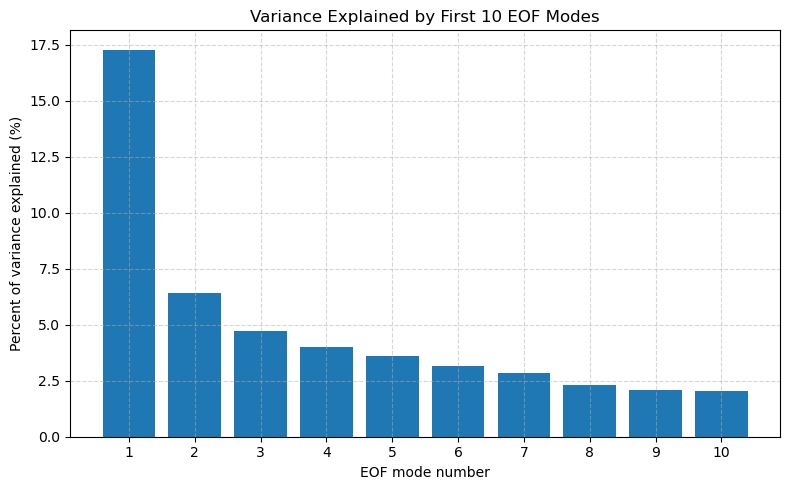

In [17]:
import matplotlib.pyplot as plt

# Plot percent of variance explained by first 10 EOFs
plt.figure(figsize=(8, 5))
plt.bar(np.arange(1, 11), variance_percent_10)
plt.xlabel("EOF mode number")
plt.ylabel("Percent of variance explained (%)")
plt.title("Variance Explained by First 10 EOF Modes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(np.arange(1, 11))
plt.tight_layout()
plt.show()


In [18]:
# Reconstruction of SST field using first 5 EOFS

reconstruction = solver.reconstructedField(5)
#reconstruction.to_netcdf('Reconstructed.nc')
reconstruction_var = xr.open_dataarray('Reconstructed.nc')

In [19]:
# This function allows the correlation in xr.corr() to be calculated using dask and handling NaNs

def nan_corr_lazy(a: xr.DataArray, b: xr.DataArray, dim="time"):
    """NaN-safe correlation computed lazily with Dask."""
    a_mean = a.mean(dim=dim, skipna=True)
    b_mean = b.mean(dim=dim, skipna=True)

    cov = ((a - a_mean) * (b - b_mean)).mean(dim=dim, skipna=True)
    std_a = a.std(dim=dim, skipna=True)
    std_b = b.std(dim=dim, skipna=True)

    corr = cov / (std_a * std_b)
    return corr.astype("float32")

# Mask grid points with all NaN time series
valid_mask = (reconstruction_var.notnull() & sst_std.notnull()).any(dim="time")
reconstruction_masked = reconstruction_var.where(valid_mask)
sst_masked = sst_std.where(valid_mask)

# Rechunk time dimension
reconstruction_masked = reconstruction_masked.chunk({"time": 60, "latitude": 128, "longitude": 128})
sst_masked = sst_masked.chunk({"time": 60, "latitude": 128, "longitude": 128})

# Compute correlation lazily
corr_map = nan_corr_lazy(reconstruction_masked, sst_std, dim="time")

from dask.diagnostics import ProgressBar
with ProgressBar():
    corr_map = corr_map.compute()


[##                                      ] | 6% Completed | 122.69 ms

/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/faa6/envs/xarray-climate/lib/python3.14/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 2.05 sms


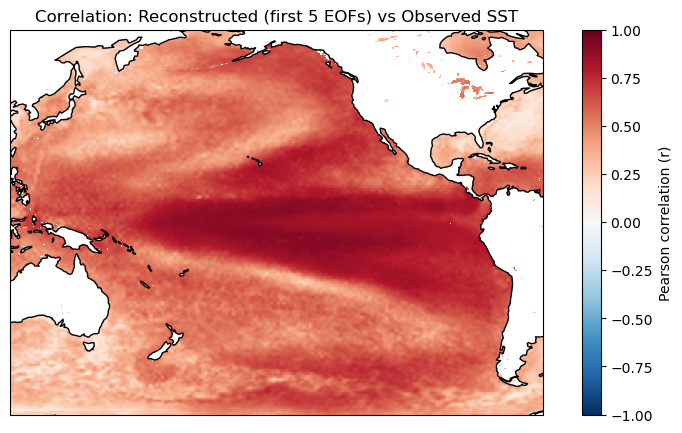

In [20]:
# Plot correlation coefficients of first 5 EOFs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

proj = ccrs.PlateCarree(central_longitude=180)

plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1, projection=proj)
pcm = corr_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={"label": "Pearson correlation (r)"}
)

ax.coastlines()
ax.set_title("Correlation: Reconstructed (first 5 EOFs) vs Observed SST")
plt.show()


In [21]:
# This function calculations correlation coefficient betwwen SST EOF1 and TCWV detrended, deseasonalized monthly mean anomalies

pc1 = xr.open_dataarray("PCs.nc").isel(mode=0)
tcwv_z = z_netcdf['tcwv']

def corr_1d_3d(x1d: xr.DataArray, field3d: xr.DataArray, dim="time"):
    """
    Compute Pearson correlation between a 1D time series (x1d)
    and each spatial gridpoint in field3d(time, lat, lon).
    NaN-safe and Dask-friendly.
    """
    x1d_mean = x1d.mean(dim=dim, skipna=True)
    field_mean = field3d.mean(dim=dim, skipna=True)

    cov = ((x1d - x1d_mean) * (field3d - field_mean)).mean(dim=dim, skipna=True)
    std_x = x1d.std(dim=dim, skipna=True)
    std_field = field3d.std(dim=dim, skipna=True)

    return (cov / (std_x * std_field)).astype("float32")
# Rechunk to stay memory-safe
tcwv_z = tcwv_z.chunk({"time": 60, "latitude": 128, "longitude": 128})
pc1 = pc1.chunk({"time": 60})

corr_map_tcwv = corr_1d_3d(pc1, tcwv_z, dim="time")

from dask.diagnostics import ProgressBar
with ProgressBar():
    corr_map_tcwv = corr_map_tcwv.compute()


[########################################] | 100% Completed | 14.95 s


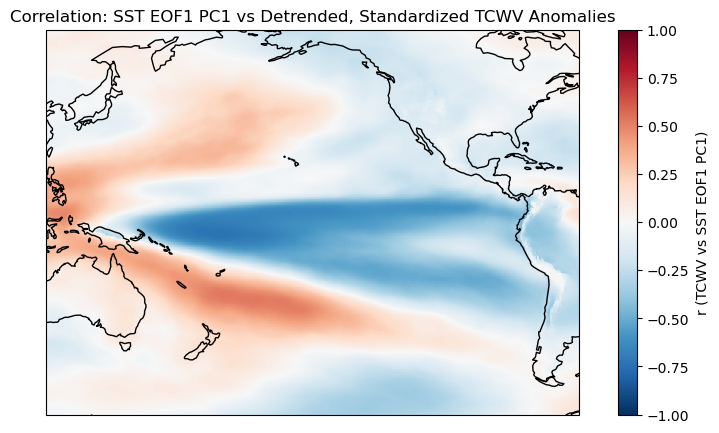

In [22]:
# Plot the correlation calculated above
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

proj = ccrs.PlateCarree(central_longitude=180)

plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1, projection=proj)

pcm = corr_map_tcwv.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={"label": "r (TCWV vs SST EOF1 PC1)"}
)

ax.coastlines()
ax.set_title("Correlation: SST EOF1 PC1 vs Detrended, Standardized TCWV Anomalies")
plt.show()


https://github.com/faa6illinois/ATMS-523-Module-4.git